## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Quadro RTX 5000, compute capability 7.5


## Load  dataset

In [3]:
DATASET_PATH = '../data/processed/mel_spec'

languages = ['Assamese', 'Bengali', 'Gujarati', 'Hindi', 'Kannada', 'Kashmiri', 'Khasi and Jaintia', 'Konkani', 'Malayalam',
             'Manipuri', 'Marathi', 'Nagamese', 'Nepali', 'Oriya', 'Punjabi', 'Tamil', 'Telegu']

artists = ['Bhupen Hazarika', 'Dipali Barthakur', 'Tarali Sarma', 'Zubeen Garg', 'Arijit Singh', 'Geeta Dutt', 'Manna Dey',
           'Shreya Ghoshal', 'Atul Purohit', 'Devang Patel', 'Falguni pathak', 'Geeta Rabari', 'Alka yagnik', 'Kishore Kumar',
           'Lata Mangeshkar', 'Sonu Nigam', 'Anuradha Bhat', 'B. K. Sumitra', 'P. B. Sreenivas', 'Rajkumar', 'Raj Begum',
           'Rashid Jahangir', 'Shameema Dev Azad', 'Waheed Jeelani', 'George Shadap', 'Rida Gatphoh', 'Soulmate',
           'Wanshankupar Suchiang', 'Amit Naik', 'Lorna Cordeiro', 'Remo Fernandes', 'Xavier Gomes', 'K J Yesudas', 'Mohanlal',
           'Shweta Mohan', 'Sujatha Mohan', 'Kunjabihari', 'Nongmaithem Pahari', 'Pinky Saikhom', 'Pushparani', 
           'Hridaynath Mangeshkar', 'Milind Ingle', 'Shridhar Phadke', 'Vaishali Samant', 'David Konyak', 'Mengu Suokhrie',
           'Silas Kikon', 'Tetseo Sisters', 'Anju Panta', 'Aruna Lama', 'Narayan Gopal', 'Raju Lama', 'Akshay Mohanty',
           'Bishnu Mohan Kabi', 'Ira Mohanty', 'Tapu Mishra', 'Gurdas Maan', 'Hans Raaj Hans', 'Jasmine Sandlas',
           'Jaswinder Brar', 'Hariharan', 'K. S. Chithra', 'S. P. Balasubrahmanyam', 'Sistla Janaki', 'LV Revanth', 'Malavika',
           'S S Thaman', 'S. P. Sailaja']

In [7]:
from src.data.load_data import get_regional_data
from src.data.split_data import train_val_split

In [8]:
dataset = get_regional_data(DATASET_PATH)

In [9]:
(X_train, y1_train, y2_train, y3_train, y4_train, y5_train), (X_val, y1_val, y2_val, y3_val, y4_val, y5_val), (X_test, y1_test, y2_test, y3_test, y4_test, y5_test) = train_val_split(dataset, 80, 10)

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y1_train, y2_train, y3_train, y4_train, y5_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y1_val, y2_val, y3_val, y4_val, y5_val))

2022-04-13 12:57:18.380767: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-13 12:57:18.797599: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13371 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5
2022-04-13 12:57:18.799866: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11131494400 exceeds 10% of free system memory.
2022-04-13 12:57:25.706185: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11131494400 exceeds 10% of free system memory.


In [9]:
def get_labels(mel, y1, y2, y3, y4, y5):
    y4 = y4 - 1
    y5 = y5 - 1
    return mel, (y1, y2, y3, y4, y5)

In [10]:
train_ds = train_ds.map(get_labels, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(get_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
for mel, (y1, y2, y3, y4, y5) in train_ds.take(1):
    print(mel.shape, y1.shape, y2.shape, y3.shape, y4.shape, y5.shape)

2022-04-13 12:57:32.198139: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11131494400 exceeds 10% of free system memory.


(128, 130) () () () () ()


Batch the training and validation sets for model training:

In [12]:
batch_size = 128
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE).cache()
val_ds = val_ds.prefetch(AUTOTUNE).cache()

In [10]:
input_shape = (128, 130)
num_langs = 17
num_artists = 68
num_gender = 2
num_songs = 340
num_local_song = 5

EPOCHS = 100
model_path = '../models/proposed_model.h5'

from src.models.proposed_network import get_model

model = get_model(input_shape, [num_langs, num_artists, num_gender, num_songs, num_local_song])

# inputlayer = layers.Input(shape=(input_shape[0], input_shape[1]))

# x = layers.Conv1D(16, 4, padding="same", activation = 'relu')(inputlayer)
# x = layers.MaxPooling1D(4,2,padding="same")(x)
# x = layers.Dropout(0.1)(x)

# x = layers.Conv1D(32, 4, padding="same", activation = 'relu')(x)
# x = layers.MaxPooling1D(4,2,padding="same")(x)
# x = layers.Dropout(0.1)(x)

# x = layers.Conv1D(32, 10, padding="same", activation = 'relu')(x)
# x = layers.MaxPooling1D(10,5,padding="same")(x)
# x = layers.Dropout(0.1)(x)

# x = layers.Conv1D(128, 10, padding="same", activation = 'relu')(x)
# x = layers.MaxPooling1D(10,5,padding="same")(x)

# x = layers.Flatten()(x)
# x = layers.BatchNormalization()(x)
# # encoder = layers.Dense(12)(x)
# # x = layers.Dense(12, name="output")(encoder)
# # attention = layers.Attention()([encoder, x])

# label1pred = layers.Dense(num_langs, name = "output1")(x)
# label2pred = layers.Dense(num_artists, name = "output2")(x)
# label3pred = layers.Dense(num_gen, name = "output3")(x)
# label4pred = layers.Dense(num_songs, name = "output4")(x)
# label5pred = layers.Dense(num_local_song, name = "output5")(x)

# model = Model(inputs=inputlayer, outputs=[label1pred, label2pred, label3pred, label4pred, label5pred])

ModuleNotFoundError: No module named 'src'

In [15]:
model.compile(
    optimizer='adam',
    loss={
            'output1':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            'output2':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            'output3':tf.keras.losses.BinaryCrossentropy(),
            'output4':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            'output5':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
         },
    metrics=['accuracy']
)

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 130)]   0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 128, 16)      8336        ['input_2[0][0]']                
                                                                                                  
 max_pooling1d_4 (MaxPooling1D)  (None, 64, 16)      0           ['conv1d_4[0][0]']               
                                                                                                  
 dropout_3 (Dropout)            (None, 64, 16)       0           ['max_pooling1d_4[0][0]']        
                                                                                            

In [17]:
tf.keras.utils.plot_model(model, '../reports/figures/proposed_network.jpg', dpi=600, show_shapes=True)

In [18]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
    callbacks=[tf.keras.callbacks.ModelCheckpoint(
            filepath=model_path,
            monitor='val_loss',
            mode='max',
            save_best_only=True
    )],
    verbose = 1
)

2022-04-13 12:57:40.830587: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11131494400 exceeds 10% of free system memory.
2022-04-13 12:57:47.414113: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11131494400 exceeds 10% of free system memory.


Epoch 1/100


2022-04-13 12:57:56.016023: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-04-13 12:57:56.560630: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1307/1307 [==============================] - 33s 23ms/step - loss: 19.1325 - output1_loss: 2.7652 - output2_loss: 3.9627 - output3_loss: 5.4784 - output4_loss: 5.2806 - output5_loss: 1.6457 - output1_accuracy: 0.1262 - output2_accuracy: 0.0605 - output3_accuracy: 0.4914 - output4_accuracy: 0.0318 - output5_accuracy: 0.2189 - val_loss: 19.9966 - val_output1_loss: 2.7882 - val_output2_loss: 3.9753 - val_output3_loss: 5.9489 - val_output4_loss: 5.6719 - val_output5_loss: 1.6119 - val_output1_accuracy: 0.1249 - val_output2_accuracy: 0.0362 - val_output3_accuracy: 0.4615 - val_output4_accuracy: 0.0232 - val_output5_accuracy: 0.2250
Epoch 2/100
1307/1307 [==============================] - 25s 19ms/step - loss: 14.0616 - output1_loss: 2.6640 - output2_loss: 3.7242 - output3_loss: 1.2451 - output4_loss: 4.8210 - output5_loss: 1.6072 - output1_accuracy: 0.1600 - output2_accuracy: 0.0954 - output3_accuracy: 0.4976 - output4_accuracy: 0.0658 - output5_accuracy: 0.2296 - val_loss: 16.8739 - val_ou

## Evaluate the model performance

Run the model on the test set and check the model's performance:

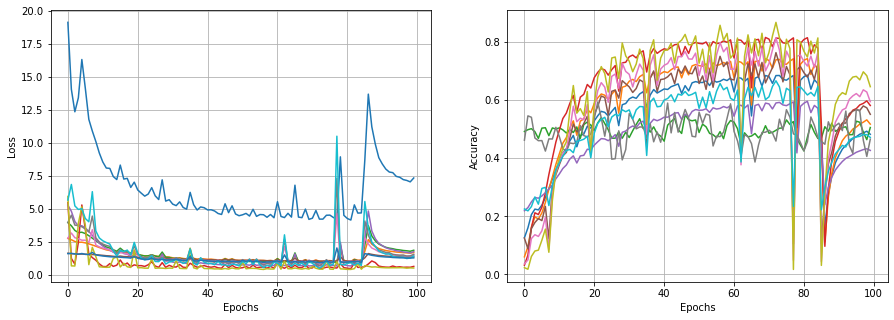

In [19]:
metrics = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

plt.plot(history.epoch, metrics['loss'])
plt.plot(history.epoch, metrics['output1_loss'])
plt.plot(history.epoch, metrics['output2_loss'])
plt.plot(history.epoch, metrics['output3_loss'])
plt.plot(history.epoch, metrics['output4_loss'])
plt.plot(history.epoch, metrics['output5_loss'])
plt.plot(history.epoch, metrics['val_output1_loss'])
plt.plot(history.epoch, metrics['val_output2_loss'])
plt.plot(history.epoch, metrics['val_output3_loss'])
plt.plot(history.epoch, metrics['val_output4_loss'])
plt.plot(history.epoch, metrics['val_output5_loss'])


plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')


plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['output1_accuracy'])
plt.plot(history.epoch, metrics['output2_accuracy'])
plt.plot(history.epoch, metrics['output3_accuracy'])
plt.plot(history.epoch, metrics['output4_accuracy'])
plt.plot(history.epoch, metrics['output5_accuracy'])
plt.plot(history.epoch, metrics['val_output1_accuracy'])
plt.plot(history.epoch, metrics['val_output2_accuracy'])
plt.plot(history.epoch, metrics['val_output3_accuracy'])
plt.plot(history.epoch, metrics['val_output4_accuracy'])
plt.plot(history.epoch, metrics['val_output5_accuracy'])

plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

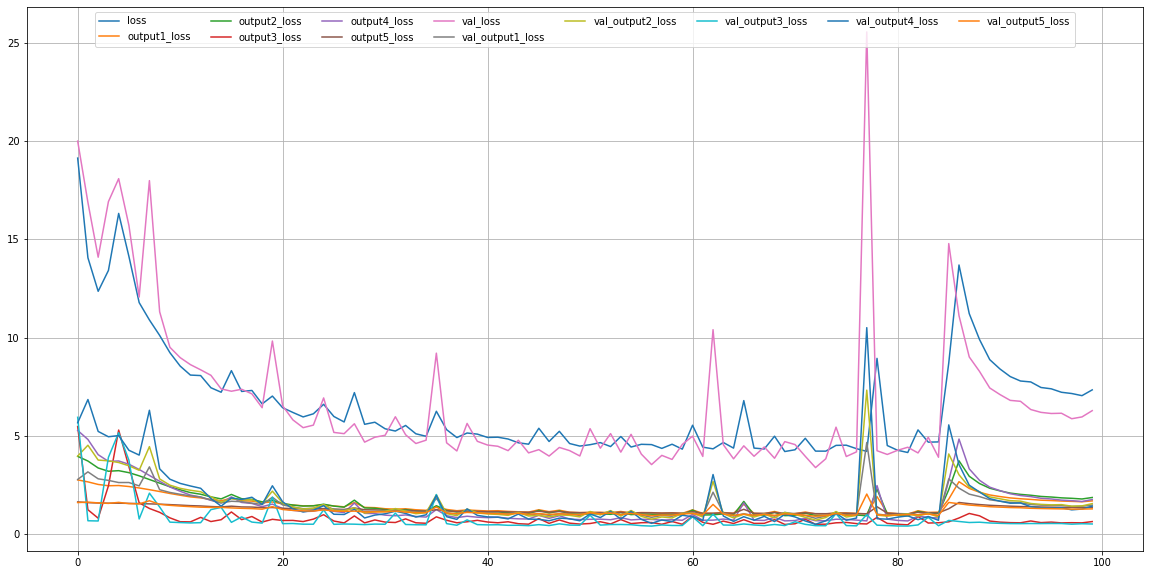

In [20]:
hist = pd.DataFrame(history.history)
hist[['loss', 'output1_loss', 'output2_loss', 'output3_loss', 'output4_loss',
       'output5_loss', 'val_loss', 'val_output1_loss', 'val_output2_loss', 'val_output3_loss',
       'val_output4_loss', 'val_output5_loss',]].plot(figsize=(20, 10))
plt.legend(loc=9, ncol=8)
plt.grid()
plt.show()

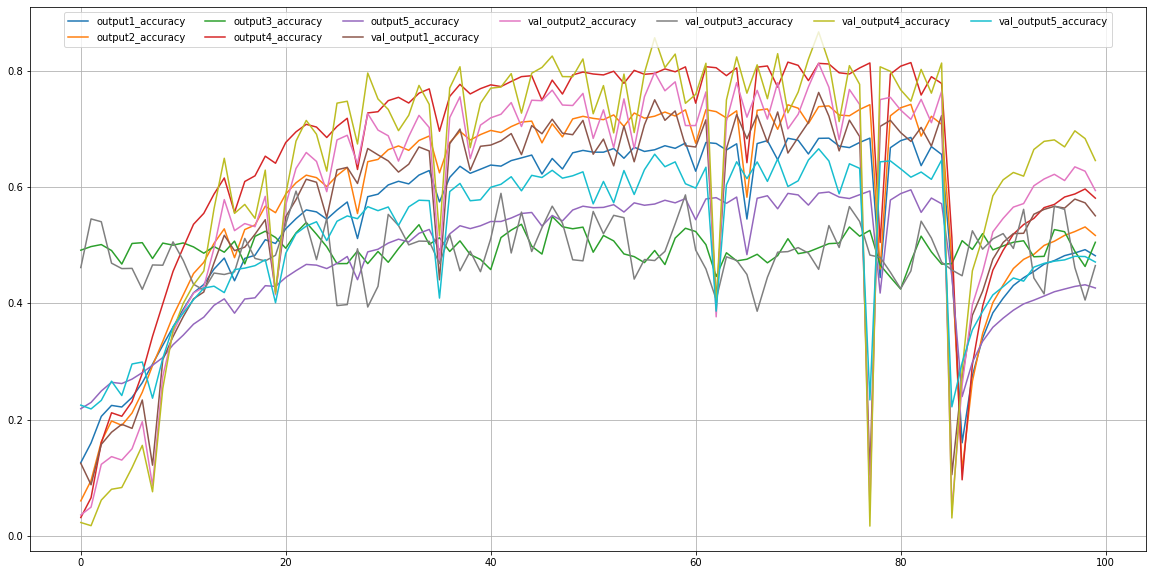

In [34]:
hist[['output1_accuracy', 'output2_accuracy', 'output3_accuracy', 'output4_accuracy',
      'output5_accuracy', 'val_output1_accuracy', 'val_output2_accuracy', 'val_output3_accuracy', 'val_output4_accuracy',
       'val_output5_accuracy']].plot(figsize=(20, 10))
plt.legend(loc=9, ncol=7)
plt.grid()
plt.show()

In [22]:
train_ds = None
val_ds = None
tf.keras.backend.clear_session()
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y1_test, y2_test, y3_test, y4_test, y5_test))
test_ds = test_ds.map(get_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size)

In [23]:
model = tf.keras.models.load_model(model_path)

In [24]:
model.evaluate(test_ds)

164/164 [==============================] - 3s 9ms/step - loss: 25.5799 - output1_loss: 4.6788 - output2_loss: 7.3264 - output3_loss: 1.0270 - output4_loss: 10.4959 - output5_loss: 2.0526 - output1_accuracy: 0.1058 - output2_accuracy: 0.0476 - output3_accuracy: 0.4891 - output4_accuracy: 0.0176 - output5_accuracy: 0.2367


[25.57994270324707,
 4.67879581451416,
 7.326444149017334,
 1.0269694328308105,
 10.495948791503906,
 2.0525667667388916,
 0.10576417297124863,
 0.047596268355846405,
 0.4890696108341217,
 0.017555609345436096,
 0.23668979108333588]

In [25]:
test_label1 = np.concatenate([y1 for mel_spec, (y1, y2, y3, y4, y5) in test_ds], axis=0)
test_label2 = np.concatenate([y2 for mel_spec, (y1, y2, y3, y4, y5) in test_ds], axis=0)
test_label3 = np.concatenate([y3 for mel_spec, (y1, y2, y3, y4, y5) in test_ds], axis=0)
test_label4 = np.concatenate([y4 for mel_spec, (y1, y2, y3, y4, y5) in test_ds], axis=0)
test_label5 = np.concatenate([y5 for mel_spec, (y1, y2, y3, y4, y5) in test_ds], axis=0)

In [26]:
y_pred1, y_pred2, y_pred3, y_pred4, y_pred5 = model.predict(test_ds, verbose=1)

164/164 [==============================] - 3s 5ms/step


In [27]:
y_true1 = test_label1
y_true2 = test_label2
y_true3 = test_label3
y_true4 = test_label4
y_true5 = test_label5

y_pred1 = np.argmax(y_pred1, axis = -1)
y_pred2 = np.argmax(y_pred2, axis = -1)
y_pred3 = np.argmax(y_pred3, axis = -1)
y_pred4 = np.argmax(y_pred4, axis = -1)
y_pred5 = np.argmax(y_pred5, axis = -1)

test_acc1 = sum(y_pred1 == y_true1) / len(y_true1)
print(f'Test set accuracy for label1: {test_acc1:.0%}')

test_acc2 = sum(y_pred2 == y_true2) / len(y_true2)
print(f'Test set accuracy for label2: {test_acc2:.0%}')

test_acc3 = sum(y_pred3 == y_true3) / len(y_true3)
print(f'Test set accuracy for label3: {test_acc3:.0%}')

test_acc4 = sum(y_pred4 == y_true4) / len(y_true4)
print(f'Test set accuracy for label4: {test_acc4:.0%}')

test_acc5 = sum(y_pred5 == y_true5) / len(y_true5)
print(f'Test set accuracy for label5: {test_acc5:.0%}')

Test set accuracy for label1: 11%
Test set accuracy for label2: 5%
Test set accuracy for label3: 49%
Test set accuracy for label4: 2%
Test set accuracy for label5: 24%


### Display a confusion matrix

Use a <a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">confusion matrix</a> to check how well the model did classifying each of the langs in the test set:


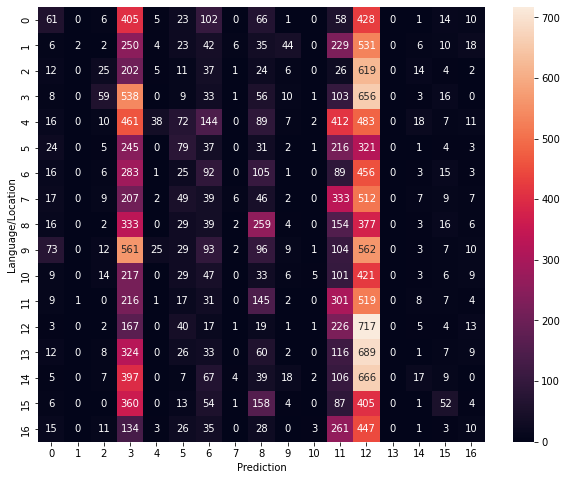

In [28]:
confusion_mtx = tf.math.confusion_matrix(y_true1, y_pred1)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            # xticklabels=languages,
            # yticklabels=languages,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Language/Location')
plt.show()

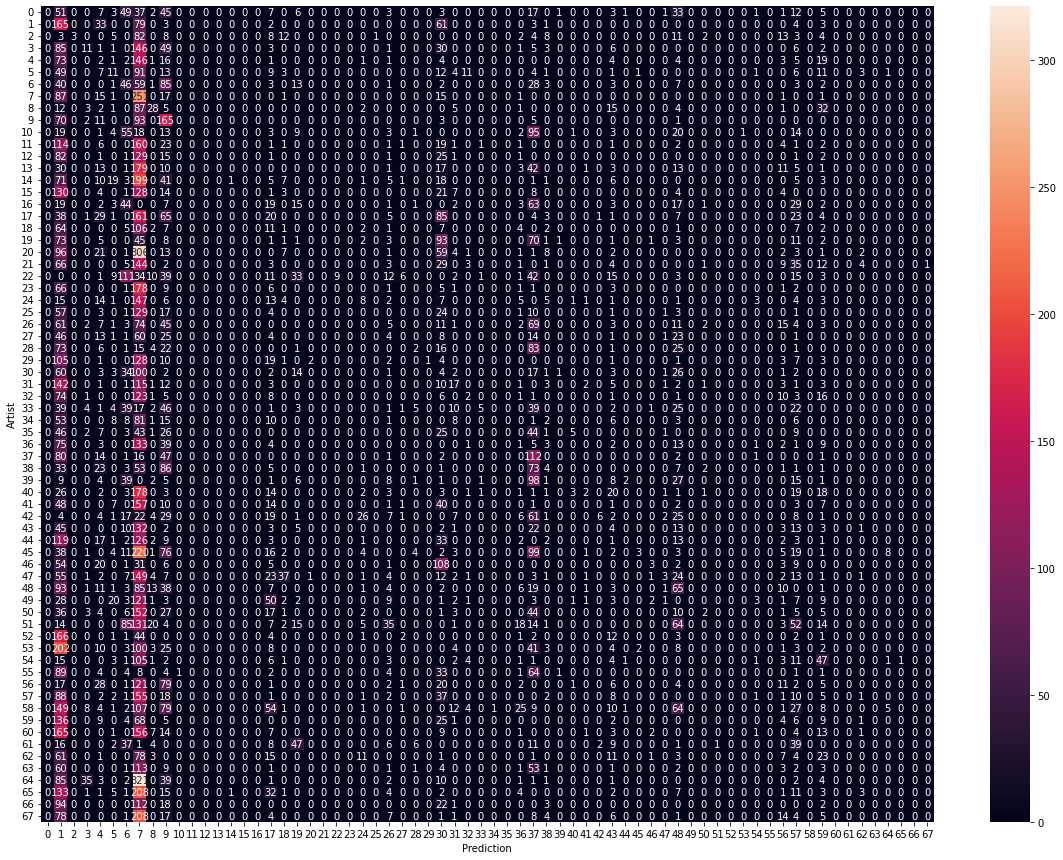

In [29]:
confusion_mtx = tf.math.confusion_matrix(y_true2, y_pred2)
plt.figure(figsize=(20, 15))
sns.heatmap(confusion_mtx,
            # xticklabels=artists,
            # yticklabels=artists,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Artist')
plt.show()

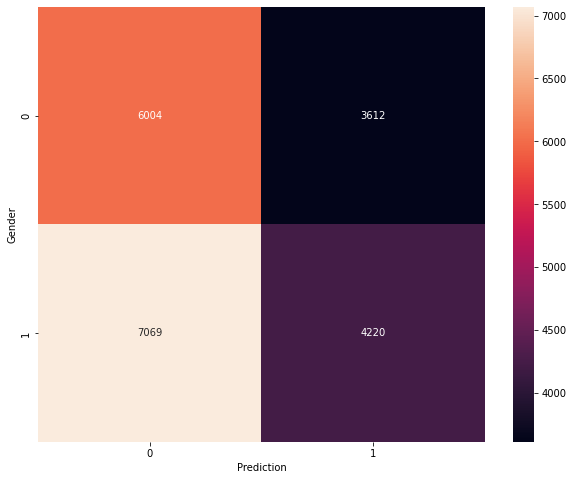

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true3, y_pred3)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            # xticklabels=artists,
            # yticklabels=artists,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Gender')
plt.show()

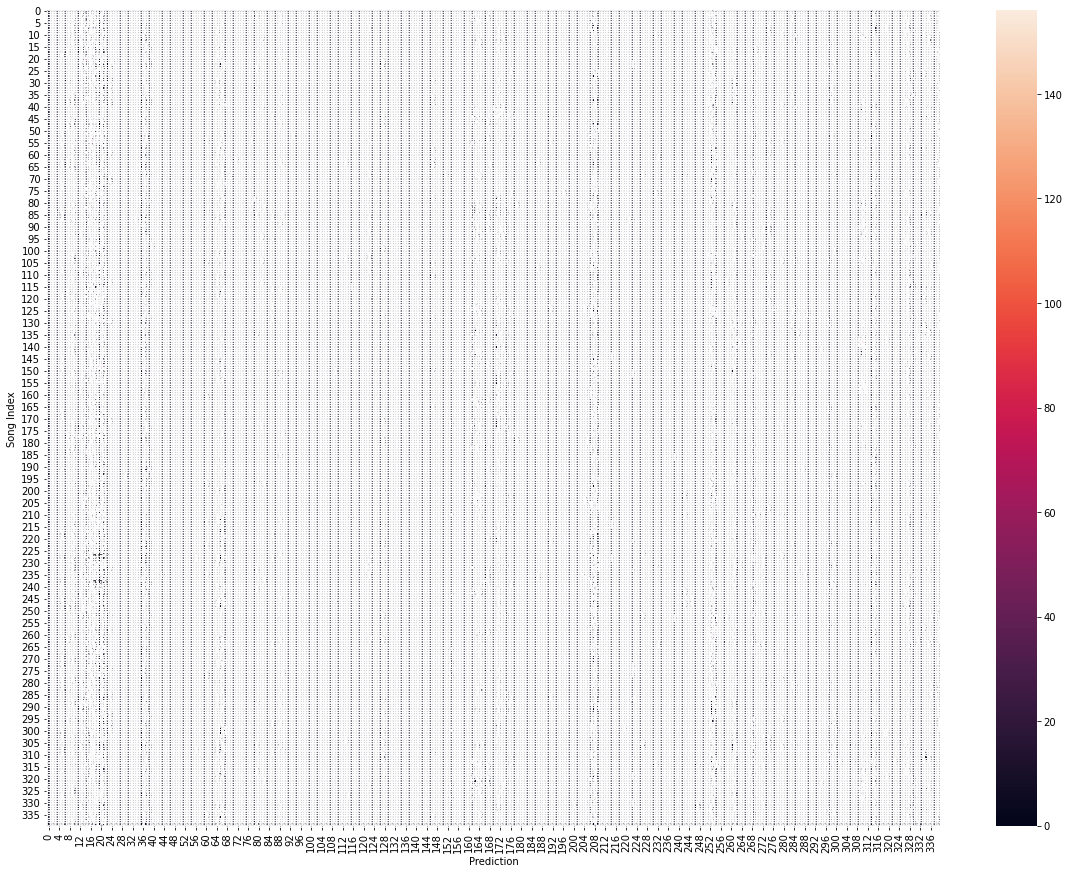

In [31]:
confusion_mtx = tf.math.confusion_matrix(y_true4, y_pred4)
plt.figure(figsize=(20, 15))
sns.heatmap(confusion_mtx,
            # xticklabels=artists,
            # yticklabels=artists,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Song Index')
plt.show()

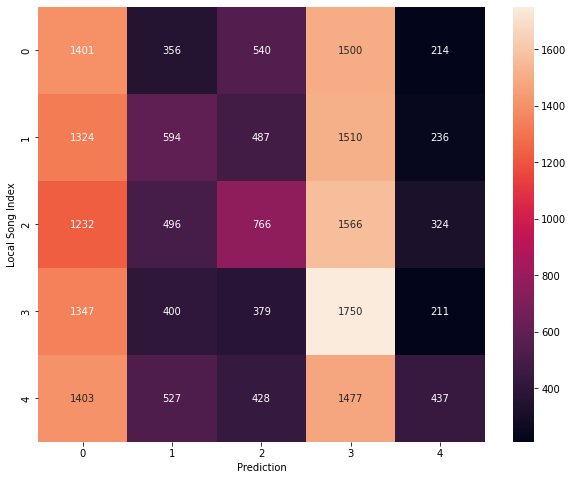

In [32]:
confusion_mtx = tf.math.confusion_matrix(y_true5, y_pred5)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            # xticklabels=artists,
            # yticklabels=artists,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Local Song Index')
plt.show()